In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 9.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=081489806a40c3d6703f6a2b8de877598c13b3d0fe5732a9df4f8bf976fd9209
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=c7c76c9650282b2c09b12f3db02b8acbcd6b8826841be8d5c6cd2289f4d003db
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
import kerastuner
import keras
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

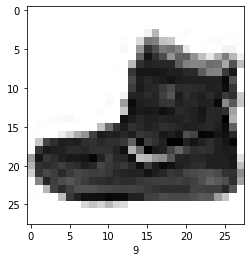

In [ ]:
plt.imshow(X_train[0], cmap='binary')
plt.xlabel(y_train[0])
plt.show()

In [ ]:
def create_model(hyperparameter):

  #initial parameters(that we want to tune) values
  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if(hyperparameter):
    num_hidden_layers = hyperparameter.Choice('num_hidden_layers', values=[1,2,3])
    num_units = hyperparameter.Choice('num_units', values=[8, 16, 32])
    dropout_rate = hyperparameter.Float('dropout_rate', min_value = 0.1, max_value=0.5)
    learning_rate = hyperparameter.Float('learning_rate', min_value=0.0001, max_value=0.01)

  model = keras.models.Sequential()

  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Lambda(lambda x: x / 255.))

  for _ in range(0, num_hidden_layers):
    model.add(keras.layers.Dense(num_units, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))

  model.add(keras.layers.Dense(10, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=['accuracy'])
  
  return model

In [ ]:
# the baseline model
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 128, step=32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)


In [ ]:
tuner = CustomTuner(create_model,
                    objective='val_accuracy',
                    max_trials=20,
                    directory='logs',
                    project_name='fashion_mnist',
                    overwrite=True)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:
tuner.search(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    epochs=5,
    verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in logs/fashion_mnist
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.005441120291766238
batch_size: 96
Score: 0.8535000085830688


In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_ = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3698 - accuracy: 0.8627 - val_loss: 0.3875 - val_accuracy: 0.8648
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3694 - accuracy: 0.8633 - val_loss: 0.3882 - val_accuracy: 0.8578
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3662 - accuracy: 0.8641 - val_loss: 0.3833 - val_accuracy: 0.8619
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3589 - accuracy: 0.8667 - val_loss: 0.4032 - val_accuracy: 0.8555
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3587 - accuracy: 0.8674 - val_loss: 0.3889 - val_accuracy: 0.8579
Epoch 6/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3540 - accuracy: 0.8692 - val_loss: 0.3847 - val_accuracy: 0.8661
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 0.3477 - accuracy: 0.8719 - val_loss: 0.3921 - val_accuracy: 0.8594
Epoch 